##Autoencoder

An autoencoder is simply a neural network that is trained to perform the task of encoding and decoding an item, such that the output of the process is as close to the original item as possible.

Encoder embeds each item in a 2D space with as much information into it as possible. The items related to each other are embedded closer to each other. The decoder on the otherhand, use the embedded information at a particular point in space and try to recreate it with the maximum amount of accuracy as possible.

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

###Preprocessing the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

In [2]:
# Parameters

IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# the images are of 28 X 28 dimension, which are scaled between 0 to 1 and
# padded to 32 X 32 for easier manipulation of the tensor shape as it passes
# through the network

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

###Autoencoder Architecture

Autoencoder is made of two parts:


*   **Encoder** network that compresses high-dimensional input data such as an
image into a lower-dimensional embedding vector

*   **Decoder** network that decompresses a given embedding vector back to the original domain (e.g., back to an image)

The autoencoder is trained to reconstruct an image, after it has passed through the encoder and back out through the decoder. The embedding is a compression of the original image into a lower-dimensional latent space. The idea is that by choosing any point in the latent space, we can generate novel images by passing this point through the decoder, since the decoder has learned how to convert points in the latent space into viable images. The latent space of an autoencoder will usually have more than two dimensions in order to have more freedom to capture greater nuance in the images.



In [5]:
# Encoder

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)

x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this

x = layers.Flatten()(x)

encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [6]:
# Decoder - a mirror image of the encoder—instead of convolutional layers, we use convolutional transpose layers

# Standard convolutional layers allow us to halve the size of an input tensor in both dimensions (height and width), by setting strides = 2.
# The convolutional transpose layer uses the same principle as a standard convolutional layer (passing a filter across the image),
# but is different in that setting strides = 2 doubles the size of the input tensor in both dimensions.

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [7]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output))  # decoder(encoder_output)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

###Compiling & training the autoencoder

In [8]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [9]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/3
600/600 [==============================] - 215s 355ms/step - loss: 0.2904 - val_loss: 0.2609
Epoch 2/3
600/600 [==============================] - 187s 312ms/step - loss: 0.2577 - val_loss: 0.2567
Epoch 3/3
600/600 [==============================] - 190s 317ms/step - loss: 0.2545 - val_loss: 0.2555


###Visualizing the Latent Space

In [10]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 8ms/step


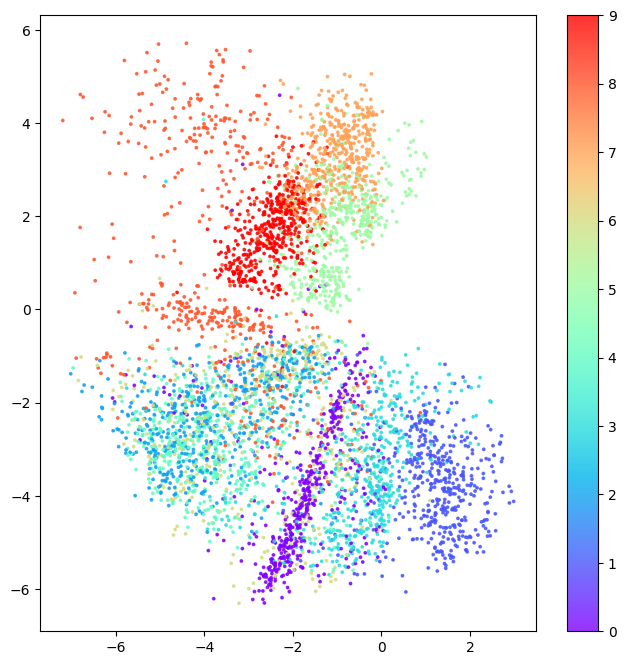

In [12]:
# Encode the example images
embeddings = encoder.predict(example_images)

# Show the encoded points in 2D space

# Colour the embeddings by their label

# ID Clothing label
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

The resulting plot is the scatter plot in which each point represents an image that has been embedded into the latent space. For example, the dark blue cloud of points in the bottom-right corner of the latent space are all different images of trousers and the red cloud of points toward the center are all ankle boots.

In [13]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [14]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 125ms/step


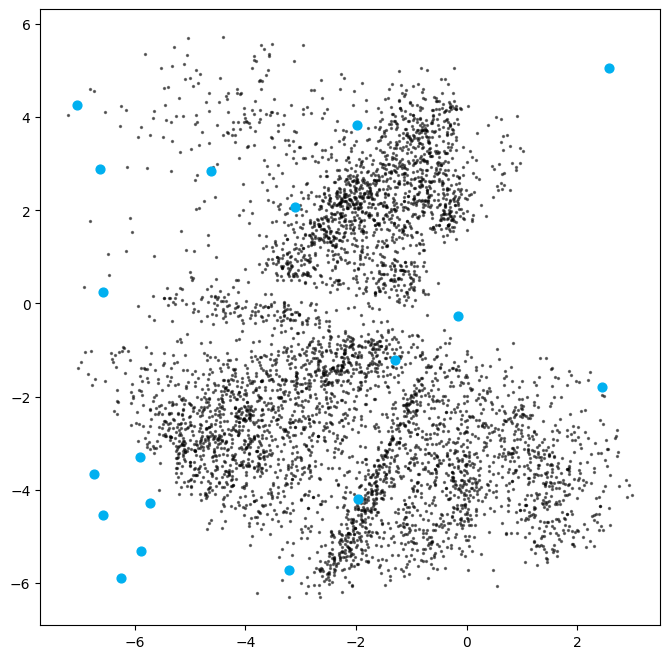

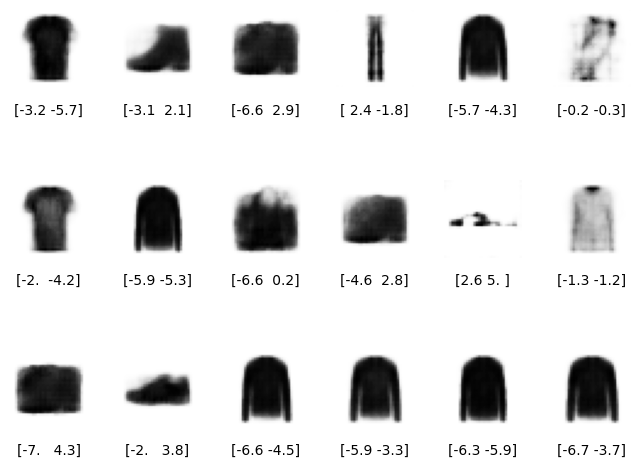

In [15]:
# Draw a plot of the original embeddings and the newly generated points in the latent space
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Each blue dot maps to one of the images shown below the diagram, with the embedding vector shown underneath.